In [38]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [39]:
np.random.seed(0)

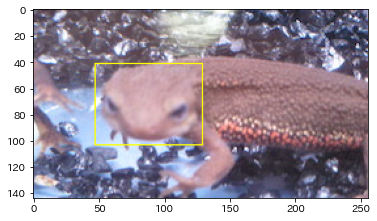

In [40]:
# read image
img = cv2.imread("../assets/imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gt = np.array((47, 41, 129, 103), dtype=np.float32)

rect = cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)

plt.imshow(img[:,:,::-1])

In [41]:
def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou

In [42]:
def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=np.int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]

    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

In [43]:
def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

In [44]:
class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

In [45]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [46]:
# crop and create database

Crop_num = 200
L = 60
H_size = 32
F_n = ((H_size // 8) ** 2) * 9

db = np.zeros((Crop_num, F_n+1))

In [47]:
for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = iou(gt, crop)

    if _iou >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

    crop_area = gray[y1:y2, x1:x2]
    crop_area = resize(crop_area, H_size, H_size)
    _hog = hog(crop_area)

    db[i, :F_n] = _hog.ravel()
    db[i, -1] = label

In [48]:
## train neural network
nn = NN(ind=F_n, lr=0.01)
for i in range(10000):
    nn.forward(db[:, :F_n])
    nn.train(db[:, :F_n], db[:, -1][..., None])

In [49]:
# read detect target image
img2 = cv2.imread("../assets/imori_many.jpg")
H2, W2, C2 = img2.shape

# Grayscale
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)

detects = np.ndarray((0, 5), dtype=np.float32)

In [50]:
# sliding window
for y in range(0, H2, 4):
    for x in range(0, W2, 4):
        for rec in recs:
            dh = int(rec[0] // 2)
            dw = int(rec[1] // 2)
            x1 = max(x-dw, 0)
            x2 = min(x+dw, W2)
            y1 = max(y-dh, 0)
            y2 = min(y+dh, H2)
            region = gray2[max(y-dh,0):min(y+dh,H2), max(x-dw,0):min(x+dw,W2)]
            region = resize(region, H_size, H_size)
            region_hog = hog(region).ravel()

            score = nn.forward(region_hog)
            if score >= 0.7:
                # cv2.rectangle(img2, (x1, y1), (x2, y2), (0,0,255), 1)
                detects = np.vstack((detects, np.array((x1, y1, x2, y2, score))))

# print(detects)

In [51]:
# Non-maximum suppression
def nms(_bboxes, iou_th=0.5, select_num=None, prob_th=None):
    #
    # Non Maximum Suppression
    #
    # Argument
    #  bboxes(Nx5) ... [bbox-num, 5(leftTopX,leftTopY,w,h, score)]
    #  iou_th([float]) ... threshold for iou between bboxes.
    #  select_num([int]) ... max number for choice bboxes. If None, this is unvalid.
    #  prob_th([float]) ... probability threshold to choice. If None, this is unvalid.
    # Return
    #  inds ... choced indices for bboxes
    #

    bboxes = _bboxes.copy()
    
    bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
    
    # Sort by bbox's score. High -> Low
    sort_inds = np.argsort(bboxes[:, -1])[::-1]

    processed_bbox_ind = []
    return_inds = []

    unselected_inds = sort_inds.copy()
    
    while len(unselected_inds) > 0:
        process_bboxes = bboxes[unselected_inds]
        argmax_score_ind = np.argmax(process_bboxes[::, -1])
        max_score_ind = unselected_inds[argmax_score_ind]
        return_inds += [max_score_ind]
        unselected_inds = np.delete(unselected_inds, argmax_score_ind)

        base_bbox = bboxes[max_score_ind]
        compare_bboxes = bboxes[unselected_inds]
        
        base_x1 = base_bbox[0]
        base_y1 = base_bbox[1]
        base_x2 = base_bbox[2] + base_x1
        base_y2 = base_bbox[3] + base_y1
        base_w = np.maximum(base_bbox[2], 0)
        base_h = np.maximum(base_bbox[3], 0)
        base_area = base_w * base_h

        # compute iou-area between base bbox and other bboxes
        iou_x1 = np.maximum(base_x1, compare_bboxes[:, 0])
        iou_y1 = np.maximum(base_y1, compare_bboxes[:, 1])
        iou_x2 = np.minimum(base_x2, compare_bboxes[:, 2] + compare_bboxes[:, 0])
        iou_y2 = np.minimum(base_y2, compare_bboxes[:, 3] + compare_bboxes[:, 1])
        iou_w = np.maximum(iou_x2 - iou_x1, 0)
        iou_h = np.maximum(iou_y2 - iou_y1, 0)
        iou_area = iou_w * iou_h

        compare_w = np.maximum(compare_bboxes[:, 2], 0)
        compare_h = np.maximum(compare_bboxes[:, 3], 0)
        compare_area = compare_w * compare_h

        # bbox's index which iou ratio over threshold is excluded
        all_area = compare_area + base_area - iou_area
        iou_ratio = np.zeros((len(unselected_inds)))
        iou_ratio[all_area < 0.9] = 0.
        _ind = all_area >= 0.9
        iou_ratio[_ind] = iou_area[_ind] / all_area[_ind]
        
        unselected_inds = np.delete(unselected_inds, np.where(iou_ratio >= iou_th)[0])

    if prob_th is not None:
        preds = bboxes[return_inds][:, -1]
        return_inds = np.array(return_inds)[np.where(preds >= prob_th)[0]].tolist()
        
    # pick bbox's index by defined number with higher score
    if select_num is not None:
        return_inds = return_inds[:select_num]

    return return_inds

In [52]:
detects = detects[nms(detects, iou_th=0.25)]

In [54]:
# Evaluation

# [x1, y1, x2, y2]
GT = np.array(((27, 48, 95, 110), (101, 75, 171, 138)), dtype=np.float32)

In [55]:
## Recall, Precision, F-score
iou_th = 0.5

Rs = np.zeros((len(GT)))
Ps = np.zeros((len(detects)))

for i, g in enumerate(GT):
    iou_x1 = np.maximum(g[0], detects[:, 0])
    iou_y1 = np.maximum(g[1], detects[:, 1])
    iou_x2 = np.minimum(g[2], detects[:, 2])
    iou_y2 = np.minimum(g[3], detects[:, 3])
    iou_w = np.maximum(0, iou_x2 - iou_x1)
    iou_h = np.maximum(0, iou_y2 - iou_y1)
    iou_area = iou_w * iou_h
    g_area = (g[2] - g[0]) * (g[3] - g[1])
    d_area = (detects[:, 2] - detects[:, 0]) * (detects[:, 3] - detects[:, 1])
    ious = iou_area / (g_area + d_area - iou_area)
    
    Rs[i] = 1 if len(np.where(ious >= iou_th)[0]) > 0 else 0
    Ps[ious >= iou_th] = 1
    

R = np.sum(Rs) / len(Rs)
P = np.sum(Ps) / len(Ps)
F = (2 * P * R) / (P + R) 

print("Recall >> {:.2f} ({} / {})".format(R, np.sum(Rs), len(Rs)))
print("Precision >> {:.2f} ({} / {})".format(P, np.sum(Ps), len(Ps)))
print("F-score >> ", F)

Recall >> 0.50 (1.0 / 2)
Precision >> 0.14 (1.0 / 7)
F-score >>  0.22222222222222224


Recall ... 正解の矩形がどれだけ検出できたか。正解をどれだけ網羅できたかを示す。[0,1]の範囲を取り、1が最高

Precision ... 検出がどれだけ正確に行われたかを示す。[0,1]の範囲を取り、1が最高

F-score ... RecallとPrecisonの調和平均。　２つのバランスを示すもので、[0,1]の範囲を取り、1が最高

In [56]:
## mAP
mAP = 0.
for i in range(len(detects)):
    mAP += np.sum(Ps[:i]) / (i + 1) * Ps[i]
mAP /= np.sum(Ps)

print("mAP >>", mAP)

mAP >> 0.0


mAP ... Mean Average Precision。物体を検出する物体検出では、mAPで測ることが多い

In [57]:
# Display
for i in range(len(detects)):
    v = list(map(int, detects[i, :4]))
    if Ps[i] > 0:
        cv2.rectangle(img2, (v[0], v[1]), (v[2], v[3]), (0,0,255), 1)
    else:
        cv2.rectangle(img2, (v[0], v[1]), (v[2], v[3]), (255,0,0), 1)

for g in GT:
    cv2.rectangle(img2, (g[0], g[1]), (g[2], g[3]), (0,255,0), 1)

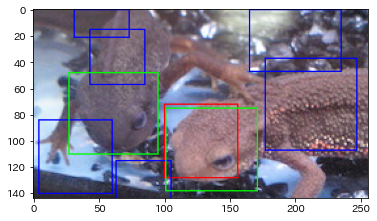

In [58]:
plt.imshow(img2[:,:,::-1])